# Test Models

This notebook tests deep learning models for enhanced JPEG reconstruction.

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys

from tensorflow.spectral import dct, idct
from scipy.fftpack import dct as DCT, idct as IDCT
from tensorflow.keras.backend import eval
import skimage.measure as metrics

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet_old, unet, my_unet

Using TensorFlow backend.


In [2]:
def dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = idct2d(block)

    return im_matrix


In [3]:
# Train and validation data paths
test_path = "/home/ubuntu/volume1/TIFF/Testing/*.tif"

# Listing train and validation images
test_images = glob.glob(test_path)

# Summary of images
print("Test set size:", len(test_images))

Test set size: 16110


In [6]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

dct_test_unc = test_unc.copy()
dct_test_compr = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, np.float32)

test_unc -= 128.0
test_compr -= 128.0

test_unc /= 128.0
test_compr /= 128.0
    
# dct_test_unc = (dct_test_unc - np.min(dct_test_unc)) / (np.max(dct_test_unc) - np.min(dct_test_unc))
# dct_test_compr = (dct_test_compr - np.min(dct_test_compr)) / (np.max(dct_test_compr) - np.min(dct_test_compr))

# First U-Net (8x8 DCT Blocks)

In [7]:
# DCT of validation set

useBlocks = True

if useBlocks:
    for ii in range(len(test_images)):
        dct_test_unc[ii,:,:,0] = dct_in_blocks(test_unc[ii,:,:,0])
        dct_test_compr[ii,:,:,0] = dct_in_blocks(test_compr[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        dct_test_unc[ii,:,:,0] = dct2d(test_unc[ii,:,:,0])
        dct_test_compr[ii,:,:,0] = dct2d(test_compr[ii,:,:,0])

In [10]:
# First U-Net (8x8 DCT Blocks)

opt=Adam(lr=0.0001)
dct_model_name = "../Models/residual_unet_DCT_data_augmentation_compress_10_20-8x8blocks-float-pretrained.hdf5"
#model = unet_old(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
dct_model=my_unet()
dct_model.compile(loss = "mse",optimizer=opt)

dct_model.load_weights(dct_model_name)

In [11]:
dct_pred = dct_model.predict(dct_test_compr)

In [12]:
img_pred_1 = test_unc.copy()

test_unc *= 128.0
test_unc += 128.0

test_compr *= 128.0
test_compr += 128.0

In [13]:
if useBlocks:
    for ii in range(len(test_images)):
        img_pred_1[ii,:,:,0] = idct_in_blocks(dct_pred[ii,:,:,0])
        img_pred_1[ii,:,:,0] = idct_in_blocks(dct_pred[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        img_pred_1[ii,:,:,0] = idct2d(dct_pred[ii,:,:,0])
        img_pred_1[ii,:,:,0] = idct2d(dct_pred[ii,:,:,0])
        
img_pred_1 *= 128.0
img_pred_1 += 128.0

# image now [0, 255.0]

In [18]:
img_pred_1 /= 255.0

# Second U-Net (Image Domain)

In [19]:
opt=Adam(lr=0.0001)
image_model_name = "../Models/residual_pseudo_unet_image_data_augmentation_compress_10_20-pretrained.hdf5"
#model = unet_old(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
image_model=my_unet()
image_model.compile(loss = "mse",optimizer=opt)

image_model.load_weights(image_model_name)

In [20]:
img_pred_2 = image_model.predict(img_pred_1)

In [23]:
img_pred_2 *= 255.0

0.0 169.0
-2.140235 154.84633


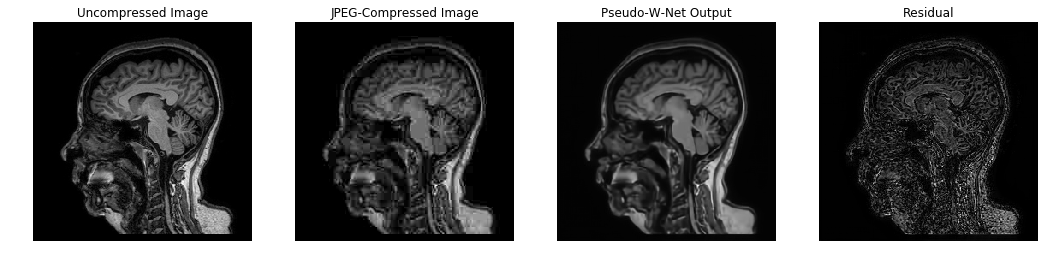

In [24]:
#print(pred)

slc = 65

print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(img_pred_2[slc,:,:,0]),np.max(img_pred_2[slc,:,:,0]))

# plt.figure(figsize = (9,18))
# plt.subplot(3,1,1)
# plt.axis("off")
# plt.title("Uncompressed Image", fontsize=24)
# plt.imshow(dct_test_unc[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,2)
# plt.axis("off")
# plt.title("Network Output", fontsize=24)
# plt.imshow(pred[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,3)
# plt.axis("off")
# plt.title("Residual", fontsize=24)
# plt.imshow((dct_test_unc[slc,:,:,0] - img_pred_2[slc,:,:,0]),cmap = "gray")
# plt.show()

plt.figure(figsize = (18,12))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Pseudo-W-Net Output")
plt.imshow(img_pred_2[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - img_pred_2[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results


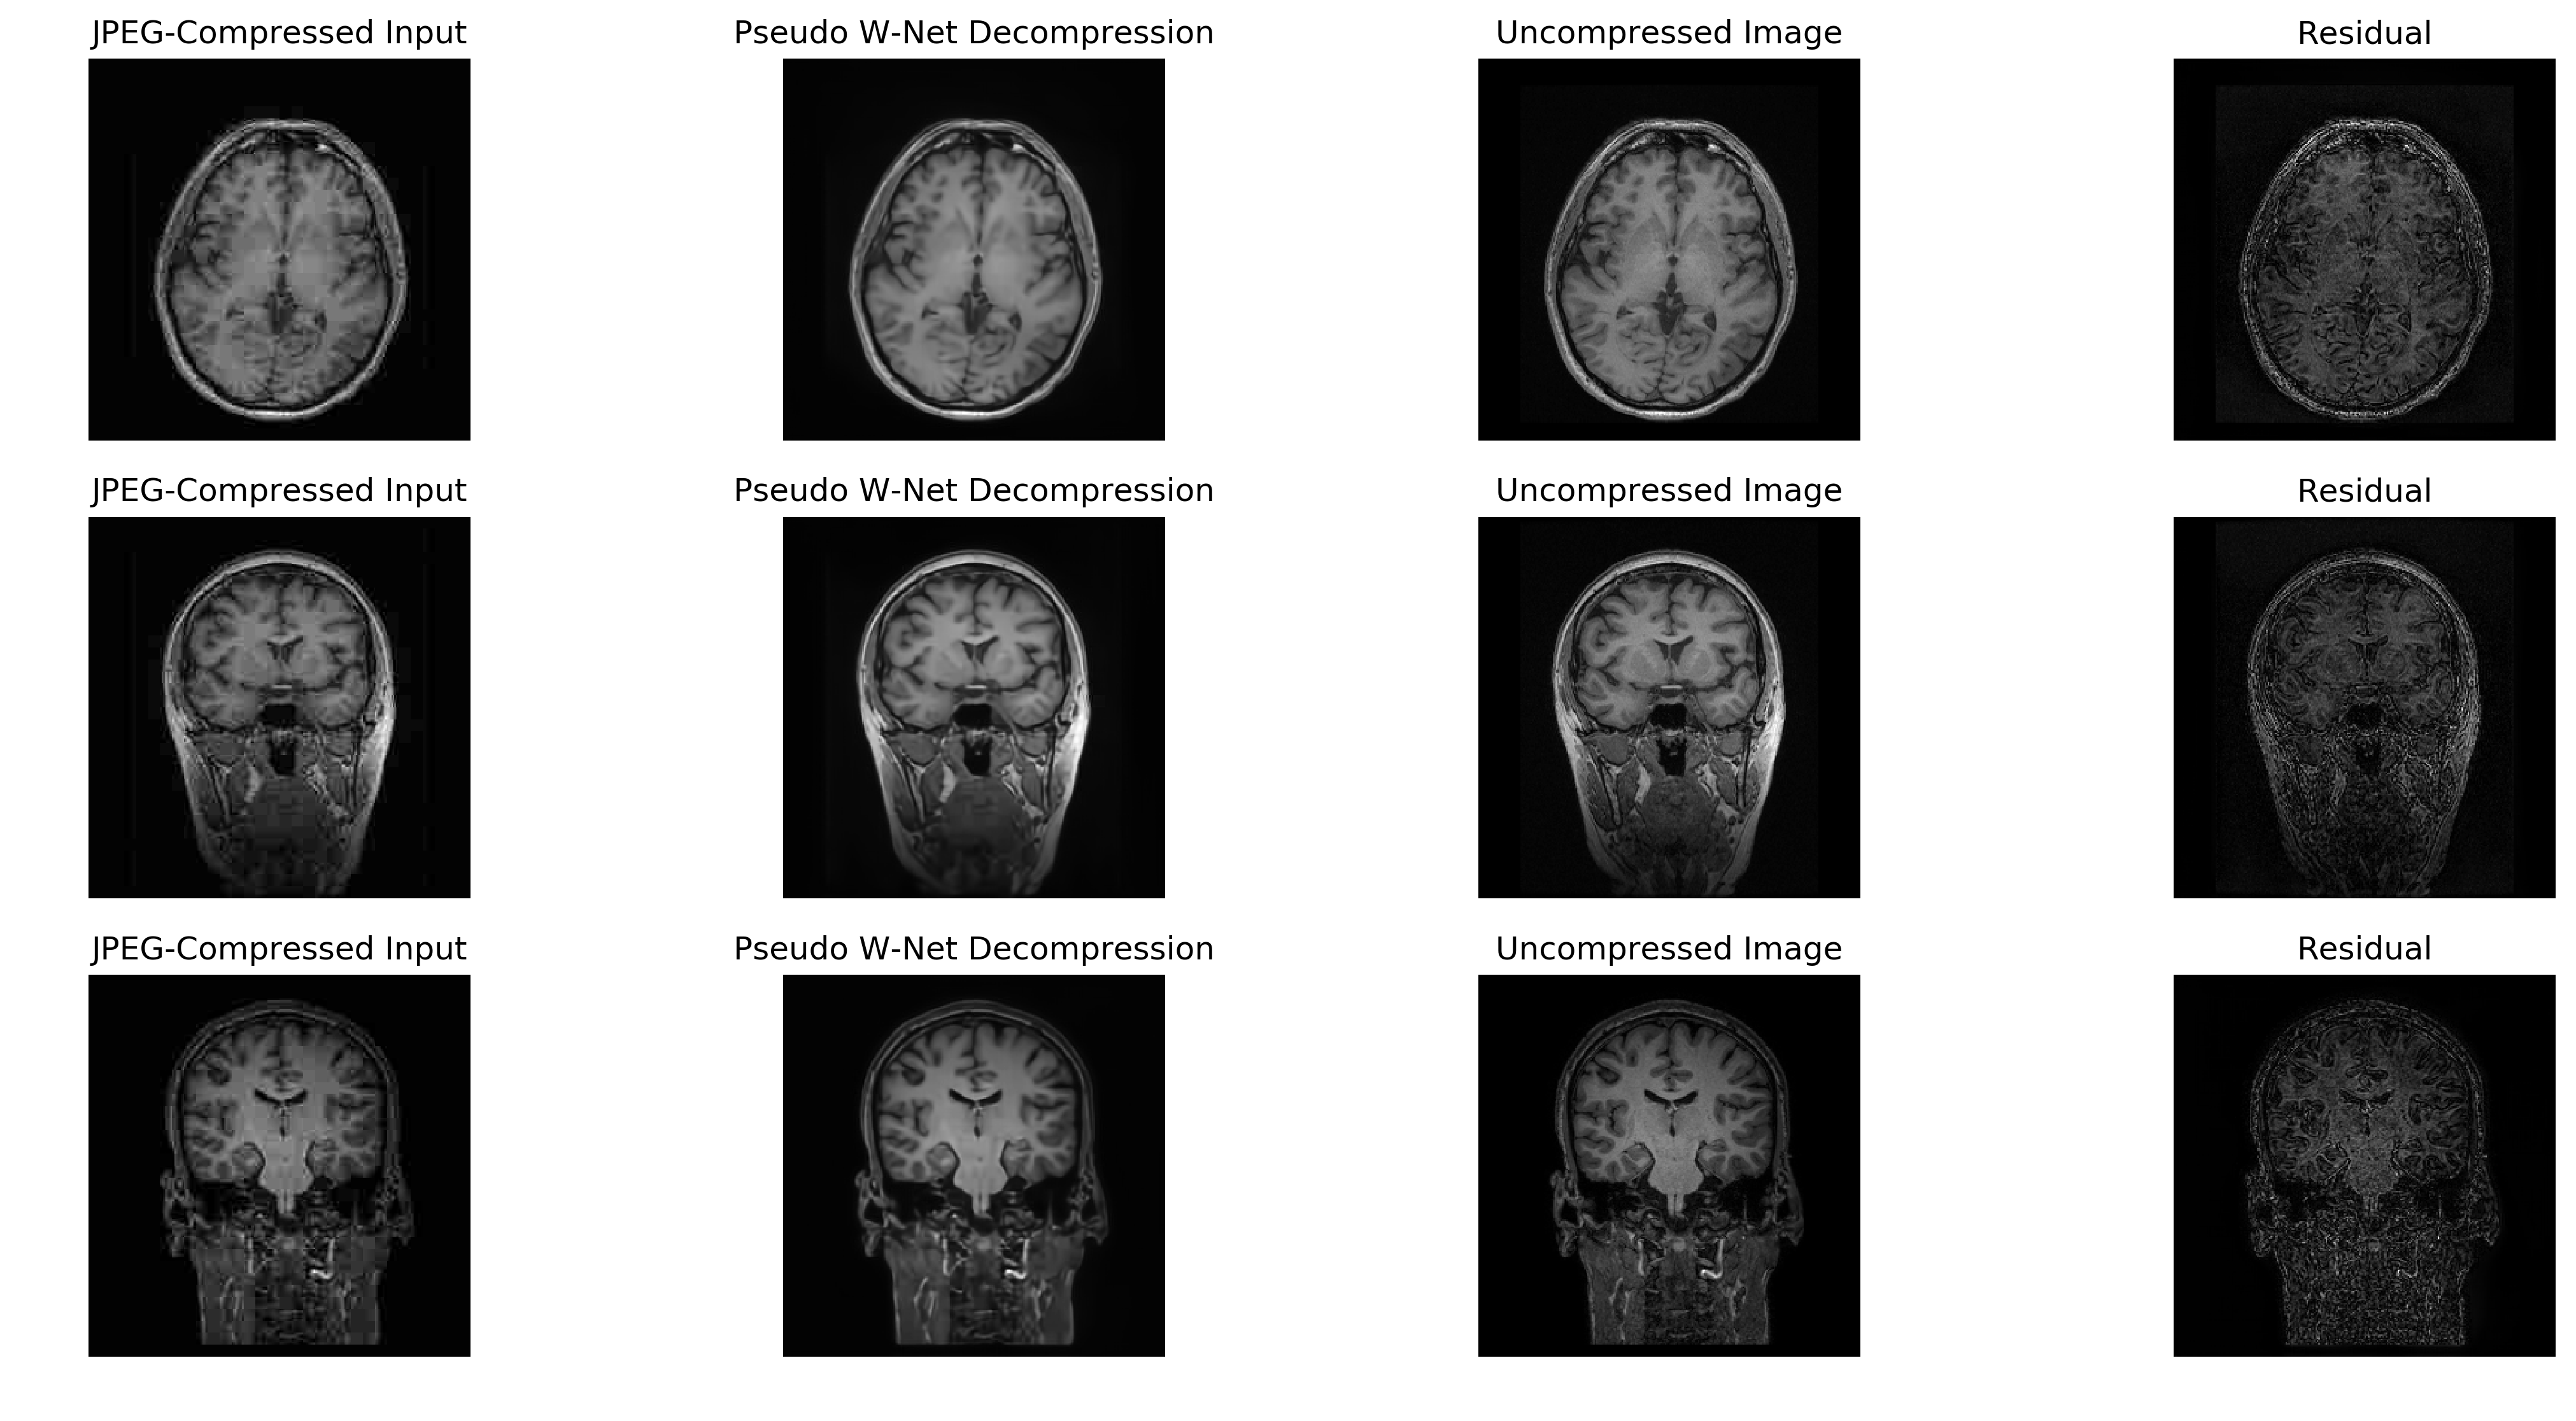

In [33]:
indexes_test = np.arange(len(test_images),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(img_pred_2[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Pseudo W-Net Decompression")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-img_pred_2[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [34]:
metr = np.zeros((len(img_pred_2),3,2),dtype=np.float32)

for ii in range(len(img_pred_2)):
    # JPEG-Compressed Metrics
    metr[ii,0,0] = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0])
    metr[ii,1,0] = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
                                        data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    metr[ii,2,0] = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    
    # Network Metrics
    metr[ii,0,1] = metrics.compare_ssim(test_unc[ii,:,:,0],img_pred_2[ii,:,:,0])
    metr[ii,1,1] = metrics.compare_psnr(test_unc[ii,:,:,0],img_pred_2[ii,:,:,0],\
                                       data_range=(img_pred_2[ii,:,:,0].max()-img_pred_2[ii,:,:,0].min()))
    metr[ii,2,1] = metrics.compare_nrmse(test_unc[ii,:,:,0],img_pred_2[ii,:,:,0],'min-max') *100.0
    
#     print(ii)
#     print(metr[ii,0,0],metr[ii,1,0],metr[ii,2,0])
#     print(metr[ii,0,1],metr[ii,1,1],metr[ii,2,1])

# only keep rows with finite values


print("JPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,0].mean(),metr[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,0].mean(),metr[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,0].mean(),metr[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,1].mean(),metr[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,1].mean(),metr[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,1].mean(),metr[:,2,1].std()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


JPEG-Compressed Metrics
SSIM: 0.475 +/- 0.175
PSNR: nan +/- nan
NRMSE: nan +/- nan


Network Metrics
SSIM: 0.346 +/- 0.084
PSNR: 23.063 +/- 2.193
NRMSE: inf +/- nan


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [35]:
tester=metr.copy()

In [36]:
for ii in range(len(tester)):
    for jj in range(3):
        for kk in range(2):
            if ~np.isfinite(tester[ii,jj,kk]):
                tester= np.delete(tester,ii,0)
                ii+=1

IndexError: index 16103 is out of bounds for axis 0 with size 16103

In [37]:
print("JPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(tester[:,0,0].mean(),tester[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(tester[:,1,0].mean(),tester[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(tester[:,2,0].mean(),tester[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(tester[:,0,1].mean(),tester[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(tester[:,1,1].mean(),tester[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(tester[:,2,1].mean(),tester[:,2,1].std()))

JPEG-Compressed Metrics
SSIM: 0.475 +/- 0.175
PSNR: 29.277 +/- 1.608
NRMSE: 3.598 +/- 0.674


Network Metrics
SSIM: 0.346 +/- 0.084
PSNR: 23.063 +/- 2.193
NRMSE: 5.503 +/- 1.198
